In [1]:
%pip install -q python-dotenv langchain-openai


[notice] A new release of pip available: 22.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI

load_dotenv()

query = '인프런에는 어떤 강의가 있나요?'

llm = ChatOpenAI(model='gpt-4o')
llm.invoke(query)


AIMessage(content='인프런은 다양한 분야의 온라인 강의를 제공하는 플랫폼입니다. 제공되는 강의 주제는 다음과 같습니다:\n\n1. **프로그래밍 및 개발**: 웹 개발, 모바일 앱 개발, 데이터베이스, 알고리즘, 인공지능 및 머신러닝 등.\n\n2. **디자인**: 그래픽 디자인, UX/UI 디자인, 3D 모델링 등.\n\n3. **비즈니스 및 마케팅**: 경영, 금융, 사업 전략, 디지털 마케팅, SEO 등.\n\n4. **자기계발**: 생산성 향상, 시간 관리, 리더십 개발 등.\n\n5. **사진 및 영상**: 사진 촬영 기법, 영상 편집, 애니메이션 제작 등.\n\n6. **음악**: 악기 연주, 음악 이론, 음악 제작 등.\n\n각 강의는 다양한 수준(초보, 중급, 고급)에 맞춰 제공되며, 수강생은 자신의 필요와 수준에 맞는 강의를 선택하여 들을 수 있습니다. 최신 강의 목록이나 상세 정보는 인프런 웹사이트를 방문하여 확인할 수 있습니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 242, 'prompt_tokens': 18, 'total_tokens': 260, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_50cad350e4', 'finish_reason': 'stop', 'logprobs': None}, id='run-15e63493-7465-4f9e-abe3-1e10defe88a5-

In [ ]:
# Rag의 목적 = 사용자의 질문에 답변하기 위해 질문과 관련된 청크(retrieve)를 생성하고, 생성된 청크를 기반으로 답변을 생성하고, 생성된 답변을 사용자에게 전달하는 것
# State = 현재 Agent의 상태
# Node = Agent가 수행하는 작업
# Edge = Node들의 관계 (실선일 경우, 반드시 발생하는 관계, 점선일 경우, 선택적인 관계)
# Conditional Edge = 조건부 관계 (조건이 만족되면, 실선의 Edge로 전환)

In [4]:
%pip install -q langgraph


[notice] A new release of pip available: 22.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph.message import add_messages
from langchain_core.messages import AnyMessage

# AnyMessage: Agent가 출력하는 모든 메시지의 부모 클래스
# SystemMessage: LLM(언어 모델) 기반의 대화형 응용프로그램(예: 챗봇)에서 대화의 맥락이나 규칙을 정해주는 특별한 메시지
# HumanMessage: 사용자가 입력한 메시지
# AgentMessage: Agent가 출력한 메시지

class AgentState(TypedDict):
    messages: list[Annotated[AnyMessage, add_messages]]


In [6]:
from langgraph.graph import StateGraph

# Node: Agent가 수행하는 작업
# Edge: Node들의 관계

graph_builder = StateGraph(AgentState)

In [7]:
def generate(state: AgentState) -> AgentState:
    messages = state['messages']
    ai_message = llm.invoke(messages)
    return {'messages': [ai_message]}

In [8]:
from langgraph.graph import START, END
graph_builder.add_node('generate', generate)
graph_builder.add_edge(START, 'generate')
graph_builder.add_edge('generate', END)

In [9]:
graph = graph_builder.compile()

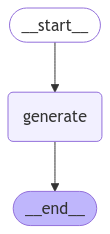

In [10]:
from IPython.display import display, Image

# 내가 생성한 Agent의 State Graph를 시각화
display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
from langchain_core.messages import HumanMessage

initial_state = {'messages': [HumanMessage(query)]}
graph.invoke(initial_state)

{'messages': [AIMessage(content='인프런에는 다양한 주제와 분야에 걸쳐 많은 강의들이 제공되고 있습니다. 일반적으로 인프런에서 찾을 수 있는 강의 주제는 다음과 같습니다:\n\n1. **프로그래밍 및 개발**: Python, Java, JavaScript, C++, React, Node.js 등 다양한 프로그래밍 언어 및 개발 프레임워크 강의\n2. **데이터 과학 및 분석**: 데이터 분석, 머신러닝, 인공지능, 빅데이터 등의 주제\n3. **웹 개발**: HTML, CSS, 웹 디자인, 풀스택 개발 등에 관련된 강의\n4. **모바일 개발**: Android, iOS 앱 개발 강의\n5. **클라우드 컴퓨팅 및 DevOps**: AWS, Azure, Docker, Kubernetes 등\n6. **디자인 및 멀티미디어**: Adobe Photoshop, Illustrator, UX/UI 디자인 강의\n7. **비즈니스 및 마케팅**: 디지털 마케팅, SEO, 사업 관리 강의\n8. **자기 계발**: 생산성, 시간 관리, 커리어 개발 등에 관한 강의\n\n이 외에도 다양한 분야에 대한 강의가 추가되고 있으며, 특정 강의의 최신 정보는 인프런 공식 웹사이트를 방문하여 확인할 수 있습니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 280, 'prompt_tokens': 18, 'total_tokens': 298, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-